In [279]:
import folium

import helpers
import pandas as pd

URL = (
    "https://data.boston.gov/api/3/action/datastore_search?resource_id"
    + "=e4bfe397-6bfc-49c5-9367-c879fac7401d&limit=49000"
)

helpers.pull_data(URL, "bike_data")

bike_data = pd.DataFrame(helpers.load_data("/bike_data.json")["records"])
bike_data = bike_data[bike_data["mode_type"] == 'bike'].reset_index()
bike_data.to_csv("out_bike.csv")

GEOJSON_PATH = "data/City_of_Boston_Boundary_(Water_Excluded).geojson"
print(bike_data.head())
m = folium.Map(location=[42.3601, -71.0589], zoom_start=12, tiles='CartoDB positron')

folium.GeoJson(GEOJSON_PATH, name="boston").add_to(m)

points = [(row['lat'], row['long']) for index, row in bike_data.iterrows()]



   index  _id             dispatch_ts mode_type location_type          street  \
0      3    4  2015-01-01 18:23:57+00      bike  Intersection            None   
1     12   13  2015-01-02 22:27:44+00      bike        Street   KENSINGTON ST   
2     26   27  2015-01-05 08:08:13+00      bike        Street      TERRACE ST   
3     30   31  2015-01-05 12:00:18+00      bike        Street  DORCHESTER AVE   
4    104  105  2015-01-12 13:28:03+00      bike  Intersection            None   

           xstreet1     xstreet2               x_cord                y_cord  \
0          OLNEY ST    INWOOD ST  772710.480000000000  2936614.620000000000   
1          DEAD END    ELMORE ST  766791.850000000000  2942087.730000000000   
2      ALLEGHANY ST     CEDAR ST  764920.290000000000  2945047.130000000000   
3          ADAMS ST     ADAMS ST  775335.450000000000  2935310.100000000000   
4  COMMONWEALTH AVE  HARVARD AVE  755895.540000000000  2952987.130000000000   

                lat               long

In [ ]:

for point in points:
    folium.Marker(location=point).add_to(m)

m

In [280]:

import matplotlib.pyplot as plt
URL = ("https://data.boston.gov/api/3/action/datastore_search?resource_id" +
       "=14e7e1a7-ffe0-4ae7-a6b4-3975fa32e879&limit=49000")
helpers.pull_data(URL, "bike_lane_data")
bike_lane_data = pd.DataFrame(helpers.load_data("/bike_lane_data.json")["records"])
bike_lane_data["STREET_NAM"] = bike_lane_data["STREET_NAM"].str.upper()
bike_lane_data.head()
abbreviations = {'NORTH': 'N', 
                     'SOUTH': 'S', 
                     'EAST': 'E', 
                     'WEST': 'W', 
                     'STREET': 'ST', 
                     'ROAD': 'RD', 
                     'AVENUE': 'AVE',
                     'PARKWAY' : 'PKWY',
                     'BOULEVARD' : 'BLVD',
                     'DRIVE' : "DR",
                     }
#abbreviating street names in dataset to make that of the bike lane dataset
for row_index in  range(len(bike_lane_data["STREET_NAM"])) :
       street_list = bike_lane_data["STREET_NAM"][row_index].split()
       for street_index in range(len(street_list)):
              word = street_list[street_index]
              if word in abbreviations.keys():
                     street_list[street_index] = abbreviations[word]
       bike_lane_data.at[row_index, "STREET_NAM"] = " ".join(street_list)
#abbreviating street names in dataset to make that of the accident dataset
for row_index in  range(len(bike_data["street"])) :
       if bike_data["street"][row_index] != None:
              street_list = bike_data["street"][row_index].split()
              for street_index in range(len(street_list)):
                     word = street_list[street_index]
                     if word in abbreviations.keys():
                            street_list[street_index] = abbreviations[word]
              bike_data.at[row_index, "street"] = " ".join(street_list)
       if bike_data["xstreet1"][row_index] != None:
              street_list = bike_data["xstreet1"][row_index].split()
              for street_index in range(len(street_list)):
                     word = street_list[street_index]
                     if word in abbreviations.keys():
                            street_list[street_index] = abbreviations[word]
              bike_data.at[row_index, "xstreet1"] = " ".join(street_list)
       if bike_data["xstreet2"][row_index] != None:
              street_list = bike_data["xstreet2"][row_index].split()
              for street_index in range(len(street_list)):
                     word = street_list[street_index]
                     if word in abbreviations.keys():
                            street_list[street_index] = abbreviations[word]
              bike_data.at[row_index, "xstreet2"] = " ".join(street_list) 


In [392]:
lane_type_dict = {
    'intersection' : 0,
    'none' : 0,
}
#lane_type_dict = dict(sorted(lane_type_dict.items(), key=lambda item: item[1], reverse=True))
              

In [393]:
#first add intersections and other crashes
intersection_crash_df = bike_data[bike_data["location_type"] == "Intersection"]
other_crash_df = bike_data[bike_data["location_type"] == "Other"]
lane_type_dict['intersection'] = intersection_crash_df.shape[0]
lane_type_dict['other'] = other_crash_df.shape[0]

In [394]:
import geopandas as gpd
from shapely.geometry import Point
# crashes = gpd.read_file('data/bike_data.json')
#convert bike_data.json into geojson


bike_lanes = gpd.read_file('data/Existing_Bike_Network_2023.geojson')



In [395]:
#find street crashes that don't occur in bike lanes
street_crash_df = bike_data[bike_data["location_type"] == "Street"].reset_index()
remove_index_list = []
for row_index in range(len(street_crash_df["street"])):
    if street_crash_df["street"][row_index] not in bike_lane_data["STREET_NAM"].values:
        lane_type_dict['none'] += 1
        remove_index_list.append(row_index)
filtered_street_crash_df = street_crash_df.drop(remove_index_list)
print(len(filtered_street_crash_df["street"]))
geometry = [Point(xy) for xy in zip(filtered_street_crash_df['long'], 
                                    filtered_street_crash_df['lat'])]

crashes_gdf = gpd.GeoDataFrame(
                            filtered_street_crash_df, 
                           crs='EPSG:4326', 
                           geometry=geometry
                           )
crashes_gdf['geometry'] = crashes_gdf.geometry.buffer(0.000127)
street_crash_gdf = gpd.sjoin(bike_lanes, crashes_gdf, how = 'inner', predicate='intersects')
street_crash_gdf.drop_duplicates(subset=['STREET_NAM', 'ExisFacil', "_id"])
print(street_crash_gdf.shape[0])

787
787


/var/folders/_y/9rdlw_714cz97090d459lrgm0000gn/T/ipykernel_86394/2020395075.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  crashes_gdf['geometry'] = crashes_gdf.geometry.buffer(0.000127)


In [396]:
#count how many accidents are in which type of bike lane
accident_occurences = street_crash_gdf["ExisFacil"].value_counts()
for index in range(len(accident_occurences)):
    lane_type_dict[accident_occurences.index[index]] = accident_occurences[index]

In [424]:
#normalize data to reflect different percentages of bike lanes + no bike lanes
URL = (
    "https://data.boston.gov/api/3/action/datastore_search?resource_id=" + 
       "6fa7932b-7bc8-42bc-9250-168d5f5dc1ad&limit=49000"
       )
helpers.pull_data(URL, "/road_data")
road_data = pd.DataFrame(helpers.load_data("/road_data.json")["records"])
total_length = road_data["SHAPESTLength"].astype(float).sum()
bike_lane_data['Shape_Leng'] = bike_lane_data['Shape_Leng'].astype(float)
bike_lane_lengths = bike_lane_data.groupby('ExisFacil')['Shape_Leng'].sum()
bike_lane_percents = bike_lane_lengths/total_length


ExisFacil
                 61.891669
BFBL           16041.422496
BL            100935.005756
BL-PEAKBUS      1454.514263
BLSL           14161.198401
CFBL            1938.809904
CFSBL            138.165426
PED              852.378090
SBL            32985.018107
SBLBL           1717.480680
SBLSL            818.212242
SLM            71973.056280
SLMTC           8280.257589
SUP            81514.839066
SUPM           31814.677975
SUPN            3728.943225
WALK            2083.991330
Name: Shape_Leng, dtype: float64
6161766.11129109


In [489]:
print(bike_lane_percents)
print(bike_lane_percents.sum())

normal_lane_dict = {}
for index in bike_lane_percents.index:
    if index in lane_type_dict.keys():
        normal_lane_dict [index] = bike_lane_percents[index]
non_bike_lane_sum = lane_type_dict['intersection'] + lane_type_dict['none'] +  lane_type_dict['other']
non_bike_lane_percent = (1-sum(bike_lane_percents.values)) / non_bike_lane_sum
normal_lane_dict['intersection'] = lane_type_dict['intersection'] * non_bike_lane_percent
normal_lane_dict['none'] = lane_type_dict['none'] * non_bike_lane_percent
normal_lane_dict['other'] = lane_type_dict['other'] * non_bike_lane_percent
lane_percent_dict = {}
for key in lane_type_dict.keys():
    lane_percent_dict[key] = lane_type_dict[key]/sum(lane_type_dict.values())
normal_lane_dict = dict(sorted(normal_lane_dict.items(), key=lambda item: item[1], reverse=True))
lane_percent_dict = {key: lane_type_dict[key] for key in normal_lane_dict}


ExisFacil
             0.000010
BFBL          0.002603
BL            0.016381
BL-PEAKBUS    0.000236
BLSL          0.002298
CFBL          0.000315
CFSBL         0.000022
PED           0.000138
SBL           0.005353
SBLBL         0.000279
SBLSL         0.000133
SLM           0.011681
SLMTC         0.001344
SUP           0.013229
SUPM          0.005163
SUPN          0.000605
WALK          0.000338
Name: Shape_Leng, dtype: float64
0.060128842251877576


{'intersection': 0.6626949373555446, 'none': 0.2514448774571106, 'other': 0.02573134293546733, 'BL': 0.016380856386400185, 'SUP': 0.013229135542186713, 'SLM': 0.011680588808495972, 'SBL': 0.00535317594190858, 'SUPM': 0.005163240116611832, 'BFBL': 0.0026033806227587727, 'BLSL': 0.002298236925063212, 'SLMTC': 0.0013438123810209696, 'SUPN': 0.0006051744187719039, 'CFBL': 0.00031465165490993563, 'SBLBL': 0.000278731884494076, 'BL-PEAKBUS': 0.00023605476695278717, 'PED': 0.0001383334055188974, 'SBLSL': 0.00013278859137739291}


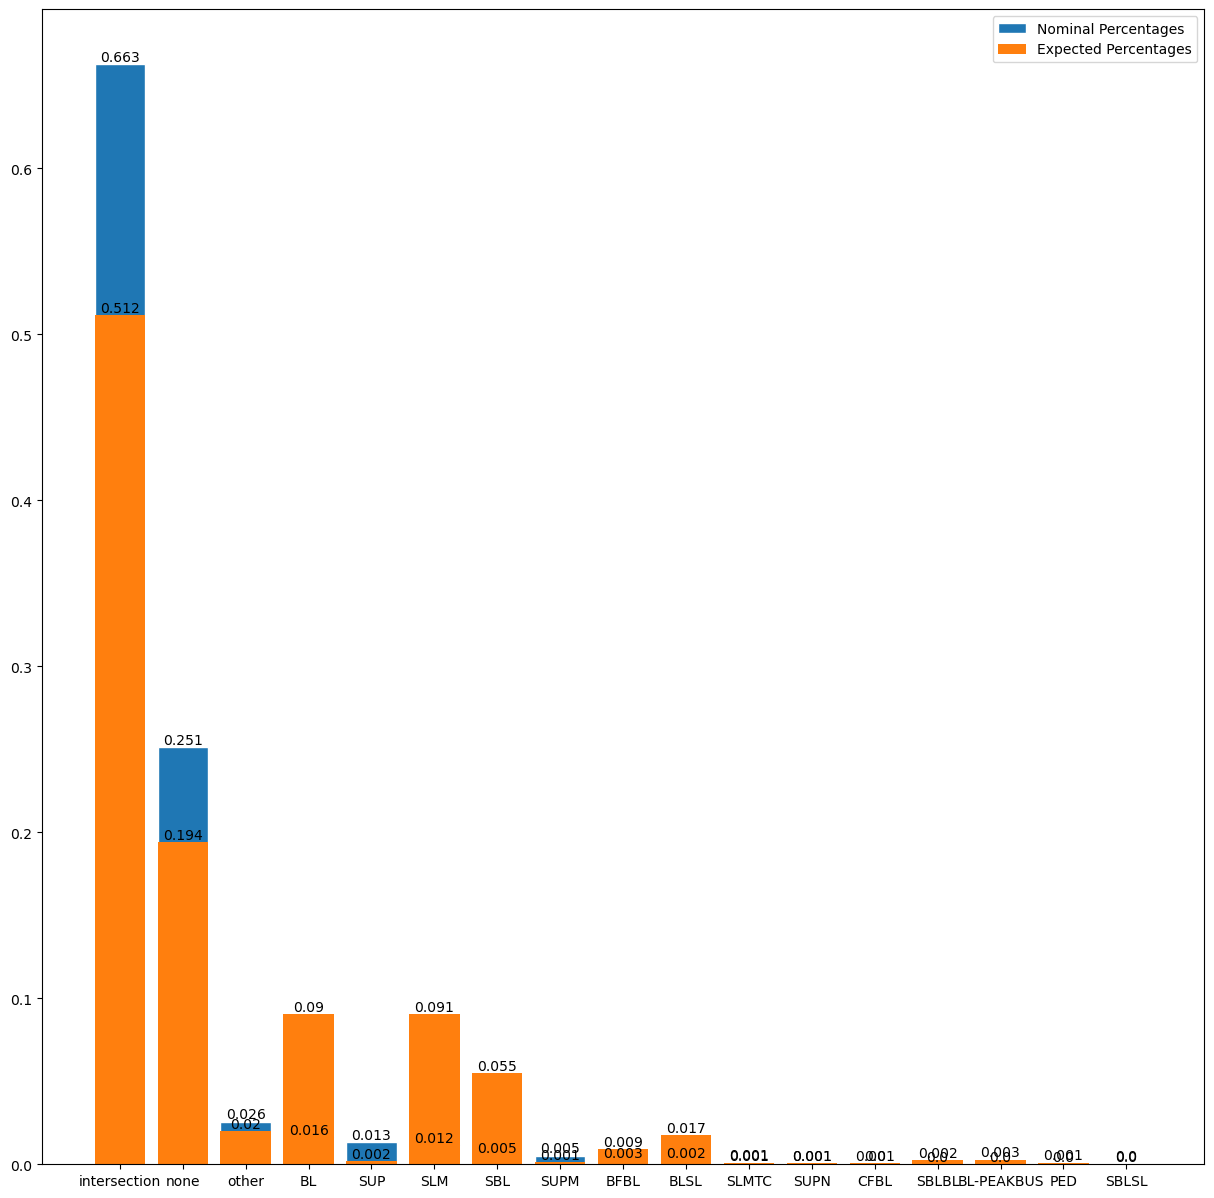

In [498]:
print(normal_lane_dict)
plt.figure(figsize=(15,15))
r = list(normal_lane_dict.values())

norm_vals = plt.bar(list(normal_lane_dict.keys()), list(normal_lane_dict.values()), edgecolor='white')
vals = plt.bar(list(normal_lane_dict.keys()), list(lane_percent_dict.values()))
plt.legend(["Nominal Percentages", "Expected Percentages"])
for bar in vals:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')
for bar in norm_vals:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 3), ha='center', va='bottom')

#plt.bar(list(normal_lane_dict.keys()), list(normal_lane_dict.values()))